# Inicio do projeto

              mean_price   final_price
timestamp                             
2023-11-11  37344.249001  37344.249001
2023-11-12  37122.722824  37122.722824
2023-11-13  37067.696982  37067.696982
2023-11-14  36549.162048  36549.162048
2023-11-15  35545.201433  35545.201433


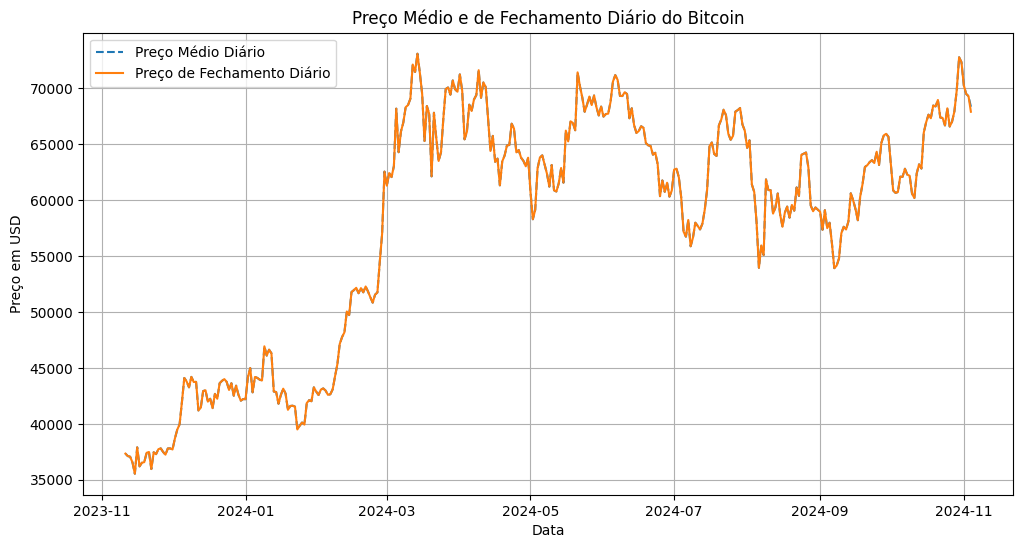

In [26]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_bitcoin_data(days=90):
    # Configurações da API da CoinGecko
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': str(days)
    }

    # Fazer requisição para a API
    response = requests.get(url, params=params)
    data = response.json()

    # Verificar se os dados foram retornados corretamente
    if 'prices' in data:
        # Criar DataFrame com os preços
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'close'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Reordenar colunas
        df = df[['close']]
        return df
    else:
        print("Erro ao obter dados:", data)
        return None

# Coletar dados
df = fetch_bitcoin_data(360)

# Agregar dados para obter o preço médio e final diário
df_daily = df.resample('D').agg({'close': ['mean', 'last']})
df_daily.columns = ['mean_price', 'final_price']  # Renomear colunas

# Exibir os primeiros dados agregados
print(df_daily.head())

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['mean_price'], label='Preço Médio Diário', linestyle='--')
plt.plot(df_daily.index, df_daily['final_price'], label='Preço de Fechamento Diário', linestyle='-')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.title('Preço Médio e de Fechamento Diário do Bitcoin')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalizar dados de fechamento
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Preparar dados para LSTM com intervalo diário
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])  # 60 dias anteriores
        Y.append(dataset[i + look_back, 0])      # Preço do dia seguinte
    return np.array(X), np.array(Y)

look_back = 60  # Usar 60 dias anteriores para prever o próximo
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Formato adequado para LSTM


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construir o modelo LSTM ajustado
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X, Y, epochs=100, batch_size=16)


Epoch 1/100


c:\Users\diogoantonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.3037 - val_loss: 0.0040
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0165 - val_loss: 0.0043
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0095 - val_loss: 0.0031
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0069 - val_loss: 0.0045
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038 - val_loss: 0.0068
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0040 - val_loss: 0.0026
E

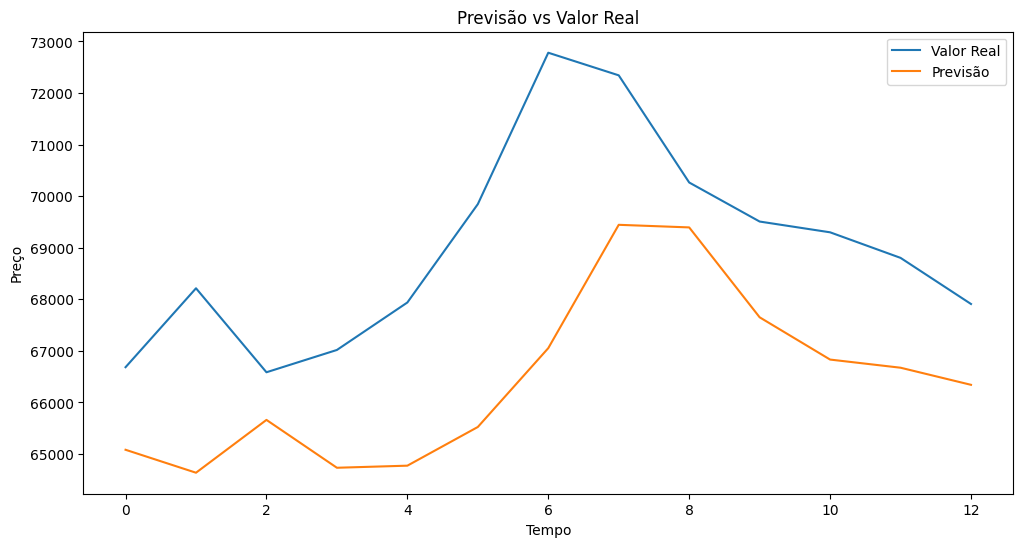

In [29]:
# Dividir os dados em treinamento e teste
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:]

# Preparar dados para treino e teste
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Ajustar dimensões para LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Treinar o modelo
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Fazer previsões e reverter a normalização
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform([Y_test])

# Calcular RMSE e MAE
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = math.sqrt(mean_squared_error(Y_test[0], predictions[:, 0]))
mae = mean_absolute_error(Y_test[0], predictions[:, 0])
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Gráfico de comparação
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(Y_test[0], label='Valor Real')
plt.plot(predictions[:, 0], label='Previsão')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.title('Previsão vs Valor Real')
plt.legend()
plt.show()
